In [1]:
from sparknlp.base import *
from sparknlp.annotator import *
from sparknlp.pretrained import PretrainedPipeline
import sparknlp
import pandas as pd
import pyspark.sql.functions as F
from pyspark.sql.functions import flatten
import glob
import os
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np
import pickle
import pyspark
from pyspark.sql import SparkSession 
from pyspark.sql.functions import col, substring
from pyspark.sql.functions import flatten
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import svm
import pickle
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    plot_confusion_matrix,
)
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import imblearn
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
import joblib
import gc
import arabic_reshaper
import matplotlib.pyplot as plt
from bidi.algorithm import get_display
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
import tensorflow.keras as keras
pd.set_option('display.max_colwidth', None)

In [38]:
gc.collect()

18300

In [2]:
spark = sparknlp.start()

In [3]:
# spark.stop()

In [4]:
datafiltered = pd.read_csv("all_filtered_final.csv")

# function nlp

In [5]:
def nlp_function(file, testing):
    if testing == True:
        df = file
    else: 
        df = spark.read\
                        .option("header", "True")\
                        .csv(file)\
                        .withColumnRenamed("description", "text")

    documentAssembler = DocumentAssembler()\
        .setInputCol("text")\
        .setOutputCol("document")\

    sentenceDetector = SentenceDetector()\
          .setInputCols(['document'])\
          .setOutputCol('sentences')

    tokenizer = Tokenizer() \
      .setInputCols(["sentences"]) \
      .setOutputCol("token")\

    normalizer = Normalizer() \
        .setInputCols(["token"]) \
        .setOutputCol("token_normalized")\

    stop_words = StopWordsCleaner.load("pretrained\\stopwords_ar_ar_2.5.4_2.4_1594742440256") \
          .setInputCols(["token_normalized"]) \
          .setOutputCol("cleanTokens")


    lemmatizer = LemmatizerModel.load("pretrained\\lemma_ar_2.7.0_2.4_1606572966993") \
          .setInputCols(["cleanTokens"]) \
          .setOutputCol("lemma")


    embeddings = BertEmbeddings.load("pretrained\\bert_embeddings_bert_mini_arabic_ar_3.4.2_3.0_1649677815613") \
        .setInputCols(["document", "lemma"]) \
        .setOutputCol("embeddings")

    nlpPipeline = Pipeline(stages=[
        documentAssembler,
        sentenceDetector,
        tokenizer,
        normalizer,
        stop_words,
        lemmatizer,
        embeddings
    ])

    empty_df = spark.createDataFrame([['']]).toDF("text")
    pipelineModel = nlpPipeline.fit(empty_df)
    result = pipelineModel.transform(df)

    final_to_run = result.select('embeddings.embeddings')
    final_to_run = final_to_run.select(flatten(final_to_run.embeddings))

    final_to_run= final_to_run.withColumnRenamed("flatten(embeddings)","embeddings")
    if testing == True:
        test = final_to_run.select('embeddings').take(1)[0][0]
        lst = [0] * (24320  -len(test))
        final_to_run = test + lst
    else:    
        length = len(final_to_run.select('embeddings').take(1)[0][0])
        final_to_run = final_to_run.select([final_to_run.embeddings[i] for i in range(length)])

    return final_to_run

# save embeddings to file

In [6]:
final_to_run = nlp_function("all_filtered_final.csv", False)
final_to_run.write.format("csv").save("bertembeddingsfinal")

# merge embeddings to one file

In [7]:
files = os.path.join("bertembeddingsfinal","*.csv")
files = glob.glob(files)
files

['bertembeddingsfinal\\part-00000-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv',
 'bertembeddingsfinal\\part-00001-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv',
 'bertembeddingsfinal\\part-00002-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv']

In [8]:
part1 = pd.read_csv('bertembeddingsfinal\\part-00000-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv', header = None)

In [9]:
part2 = pd.read_csv('bertembeddingsfinal\\part-00001-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv', header = None)

In [10]:
part3 = pd.read_csv('bertembeddingsfinal\\part-00002-063837a9-26c7-4ca9-92bb-45b9c2b7ed6d-c000.csv', header = None)

In [51]:
df_all_embeddings = pd.concat([part1, part2, part3], axis =0)

In [67]:
df_all_embeddings.shape

(10504, 24320)

In [53]:
df_all_embeddings = df_all_embeddings.fillna(0)

In [66]:
df_all_embeddings.head(1)

,0,1,2,3,4,5,6,7,8,9,...,24310,24311,24312,24313,24314,24315,24316,24317,24318,24319
0,0.354644,-0.345873,1.658191,0.279144,-0.715627,-0.010102,1.02706,-0.988201,-0.43264,0.094906,...,1.134737,-0.961213,0.803158,0.507372,-0.872288,1.108102,-1.344112,-1.326309,0.012405,1.23402


# Save Final File (embeddings)

In [68]:
df_all_embeddings.to_csv('all_final_embeddingsfinal.csv', index = False)

In [8]:
df_all_embeddings = pd.read_csv("final upload bod\\all_final_embeddingsfinal.csv")

In [9]:
df_all_embeddings.shape

(10504, 24320)

# Pre-processing

In [10]:
x = df_all_embeddings
Y = datafiltered['y']
y = LabelEncoder().fit_transform(Y)

In [11]:
class_count_accepted, class_count_rejected, class_count_medical = Y.value_counts()

class_accepted = Y[Y == 'تكفل']
class_rejected = Y[Y== 'استبعاد']
class_medical = Y[Y == 'توجيه طبي']
print('class_accepted:', class_accepted.shape)
print('class_rejected:', class_rejected.shape)
print('class_medical:', class_medical.shape)

class_accepted: (8248,)
class_rejected: (1651,)
class_medical: (605,)


In [12]:
# fig, ax = plt.subplots()
# acc = get_display(arabic_reshaper.reshape("تكفل"))
# rej = get_display(arabic_reshaper.reshape("استبعاد"))
# med = get_display(arabic_reshaper.reshape("توجيه طبي"))

# rects1 = ax.bar(df['y'].unique(), df['y'].value_counts().sort_values())
# ax.set_xticklabels([acc, rej,med])
# plt.show()

In [13]:
print(Counter(y))

Counter({1: 8248, 0: 1651, 2: 605})


#### sampled

In [14]:
# #undersampling
undersample = RandomUnderSampler(sampling_strategy={0: 1651, 1: 3000, 2: 605})
X_under, y_under = undersample.fit_resample(x, y)
print(Counter(y_under))

Counter({1: 3000, 0: 1651, 2: 605})


In [15]:
# #oversampling
# oversample = RandomOverSampler(sampling_strategy='minority')
# X_over, y_over = oversample.fit_resample(x, y)

# print(Counter(y_over))

In [16]:
#oversampling by SMOTE
oversample = SMOTE(sampling_strategy='all')
x_smote, y_smote = oversample.fit_resample(X_under, y_under)
print(Counter(y_smote))

Counter({0: 3000, 1: 3000, 2: 3000})


In [17]:
X_train_s, X_test_s, y_train_s, y_test_s = train_test_split(x_smote, y_smote,
    test_size=0.20,
    random_state=1,
    shuffle=True,
    stratify=y_smote,
    )

#### not sampled (weighted model)

In [18]:
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(x, y,
    test_size=0.20,
    random_state=1,
    shuffle=True,
    stratify=y,
    )

In [19]:
x.shape[0]

10504

In [20]:
unique_classes = [0,1,2]
our_dict = {}
for classes in unique_classes:
    our_dict[classes] = x.shape[0]/(x.loc[y == classes].shape[0]) * len(unique_classes)

In [21]:
our_dict

{0: 19.086614173228348, 1: 3.8205625606207567, 2: 52.085950413223145}

In [17]:
# from sklearn.utils import class_weight
# class_weight.compute_class_weight('balanced', np.unique(y_train_n), y_train_n)

# Model

## Random Forest

##### with sampling

In [ ]:
# RF_s = RandomForestClassifier()

# param_gridRF_s = [
# {
# "n_estimators":[100,1000,2000, 3000],
# "min_samples_leaf":[1,10,100, 1000],
# "max_leaf_nodes":[300,500,700,900],
# "max_samples":[300,500,700,900],
#  },
    
#  ]

# gridsearchRF_s = GridSearchCV(RF_s, param_gridRF_s, cv=3, verbose=1, n_jobs=-1) 
# best_modelRF_s = gridsearchRF_s.fit(X_train_s.values,y_train_s)

Fitting 3 folds for each of 256 candidates, totalling 768 fits


In [ ]:
# gridsearchRF_s.cv_results_

In [ ]:
# plot.grid_search(gridsearchRF_s.cv_results_, change='n_estimators', kind='bar')

In [ ]:
# print("\n The best estimator across ALL searched params:\n",gridsearchRF_s.best_estimator_)
# print("\n The best score across ALL searched params:\n",gridsearchRF_s.best_score_)
# print("\n The best parameters across ALL searched params:\n",gridsearchRF_s.best_params_)

In [ ]:
# accuracy_train = accuracy_score(y_train_s, best_modelRF.predict(X_train_s))
# print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
# accuracy_test = accuracy_score(y_test_s, best_modelRF.predict(X_test_s))
# print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))

In [ ]:
# print(gridsearchRF.score(X_valid,y_valid))
# print(best_modelRF.best_params_)

In [28]:
#RF = RandomForestClassifier(n_estimators=1000, bootstrap = False, n_jobs=-1 ,max_leaf_nodes = 800)
RF = RandomForestClassifier(n_estimators=2000, n_jobs=-1 ,max_leaf_nodes = 100, max_features = 200)

RF.fit(X_train_s.values, y_train_s)

RandomForestClassifier(max_features=200, max_leaf_nodes=100, n_estimators=2000,
                       n_jobs=-1)

In [29]:
accuracy_train = accuracy_score(y_train_s, RF.predict(X_train_s))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
accuracy_test = accuracy_score(y_test_s, RF.predict(X_test_s))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))

C:\Users\Me.Amin\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(



Train Accuracy: 91.90%


C:\Users\Me.Amin\AppData\Local\Continuum\anaconda3\envs\myenv\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


Test Accuracy: 76.67%


In [24]:
precision = precision_score(y_test_s, RF.predict(X_test_s.values), average='micro')
print(precision)
recall = recall_score(y_test_s, RF.predict(X_test_s.values), average='micro')
print(recall)
score = f1_score(y_test_s, RF.predict(X_test_s.values), average='micro')
print(score)
#'micro', macro', 'weighted'

0.8011111111111111
0.8011111111111111
0.8011111111111111


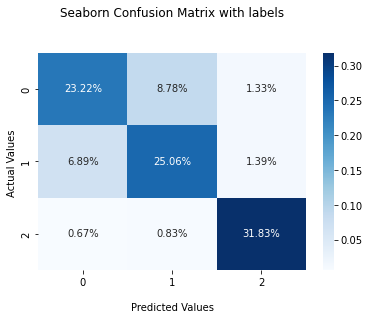

In [25]:
cf_matrix = confusion_matrix(y_test_s, RF.predict(X_test_s.values))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

In [132]:
def roc_auc_score_multiclass(actual_class, pred_class, average = "macro"):
    
    #creating a set of all the unique classes using the actual class list
    unique_class = set(actual_class)
    roc_auc_dict = {}
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc

    return roc_auc_dict

In [134]:
roc_auc_dict = roc_auc_score_multiclass(y_valid,  RF.predict(X_valid))
roc_auc_dict

{0: 0.806789421378414, 1: 0.7878451874057838, 2: 0.9661675635078522}

In [116]:
filename = 'finalRF.joblib'
joblib.dump(RF, filename)

['finalRF.joblib']

#### without sampling

In [117]:
RF_n = RandomForestClassifier(class_weight = "balanced_subsample",
                            n_estimators=500, max_leaf_nodes = 500, n_jobs = -1, max_samples = 800)
RF_n.fit(X_train_n.values, y_train_n)

RandomForestClassifier(class_weight='balanced_subsample', max_leaf_nodes=500,
                       max_samples=800, n_estimators=500, n_jobs=-1)

In [118]:
accuracy_train = accuracy_score(y_train_n, RF_n.predict(X_train_n.values))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
accuracy_test = accuracy_score(y_test_n, RF_n.predict(X_test_n.values))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 78.92%
Test Accuracy: 78.91%


In [119]:
precision = precision_score(y_test_n, RF_n.predict(X_test_n.values), average='weighted')
print(precision)
recall = recall_score(y_test_n, RF_n.predict(X_test_n.values), average='weighted')
print(recall)
score = f1_score(y_test_n, RF_n.predict(X_test_n.values), average='weighted')
print(score)
#'micro', macro', 'weighted'

0.8337765125837058
0.789148024750119
0.6998672317246871


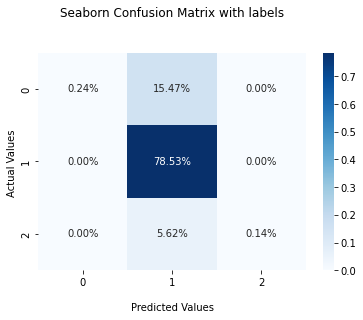

In [120]:
cf_matrix = confusion_matrix(y_test_n, RF_n.predict(X_test_n.values))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

## KNN

##### with sampling

In [144]:
knn = KNeighborsClassifier(n_jobs = -1)
knn.fit(X_train_s.values, y_train_s)

KNeighborsClassifier(n_jobs=-1)

In [145]:
accuracy_train_knn = accuracy_score(y_train_s, knn.predict(X_train_s.values))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train_knn*100))
accuracy_test_knn = accuracy_score(y_test_s, knn.predict(X_test_s.values))
print('Test Accuracy:{: .2f}%'.format(accuracy_test_knn*100))


Train Accuracy: 65.76%
Test Accuracy: 63.39%


In [146]:
precision = precision_score(y_test_s, knn.predict(X_test_s.values), average='micro')
print(precision)
recall = recall_score(y_test_s, knn.predict(X_test_s.values), average='micro')
print(recall)
score = f1_score(y_test_s, knn.predict(X_test_s.values), average='micro')
print(score)
#'micro', macro', 'weighted'

0.6338888888888888
0.6338888888888888
0.6338888888888888


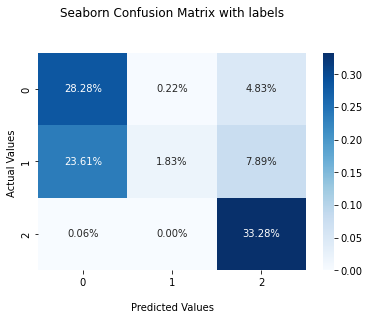

In [147]:
cf_matrix = confusion_matrix(y_test_s, knn.predict(X_test_s.values))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

##### without sampling

In [148]:
knn_n = KNeighborsClassifier(n_jobs = -1)
knn_n.fit(X_train_n.values, y_train_n)

KNeighborsClassifier(n_jobs=-1)

In [149]:
accuracy_train = accuracy_score(y_train_n, knn_n.predict(X_train_n.values))
print('\nTrain Accuracy:{: .2f}%'.format(accuracy_train*100))
accuracy_test = accuracy_score(y_test_n, knn_n.predict(X_test_n.values))
print('Test Accuracy:{: .2f}%'.format(accuracy_test*100))


Train Accuracy: 84.04%
Test Accuracy: 78.11%


In [153]:
precision = precision_score(y_test_n, knn_n.predict(X_test_n.values), average='weighted')
print(precision)
recall = recall_score(y_test_n, knn_n.predict(X_test_n.values), average='weighted')
print(recall)
score = f1_score(y_test_n, knn_n.predict(X_test_n.values), average='weighted')
print(score)
#'micro', macro', 'weighted'

0.7265629566538908
0.7810566396953832
0.7447561953810942


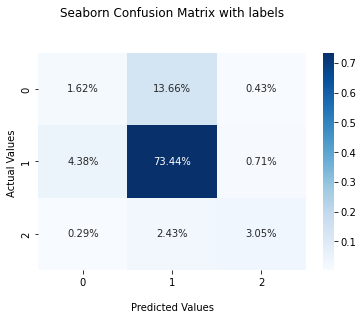

In [151]:
cf_matrix = confusion_matrix(y_test_n, knn_n.predict(X_test_n.values))
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

plt.show()

## DNN

##### with sampling

In [155]:
model = tf.keras.models.Sequential()

model.add(tf.keras.layers.Dense(32, input_shape = (24320, ),activation=tf.nn.relu))
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Dense(16,activation=tf.nn.sigmoid))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))



In [156]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [157]:
model.fit(X_train_s, y_train_s, epochs=5, validation_split=0.20, verbose =1)

Epoch 1/5
180/180 [==============================] - 48s 263ms/step - loss: 1.0089 - accuracy: 0.4729 - val_loss: 0.7355 - val_accuracy: 0.6403
Epoch 2/5
180/180 [==============================] - 54s 299ms/step - loss: 0.8489 - accuracy: 0.5648 - val_loss: 0.6826 - val_accuracy: 0.6660
Epoch 3/5
180/180 [==============================] - 46s 253ms/step - loss: 0.7916 - accuracy: 0.5863 - val_loss: 0.6310 - val_accuracy: 0.6722
Epoch 4/5
180/180 [==============================] - 44s 247ms/step - loss: 0.7689 - accuracy: 0.5969 - val_loss: 0.6249 - val_accuracy: 0.6681
Epoch 5/5
180/180 [==============================] - 46s 256ms/step - loss: 0.7330 - accuracy: 0.6090 - val_loss: 0.6031 - val_accuracy: 0.7035


In [158]:
model.fit(X_train_s, y_train_s, epochs=5, validation_split=0.20, verbose =1)

Epoch 1/5
180/180 [==============================] - 45s 249ms/step - loss: 0.7042 - accuracy: 0.6198 - val_loss: 0.5871 - val_accuracy: 0.6840
Epoch 2/5
180/180 [==============================] - 44s 243ms/step - loss: 0.6923 - accuracy: 0.6356 - val_loss: 0.5833 - val_accuracy: 0.6931
Epoch 3/5
180/180 [==============================] - 44s 245ms/step - loss: 0.6788 - accuracy: 0.6253 - val_loss: 0.5721 - val_accuracy: 0.7139
Epoch 4/5
180/180 [==============================] - 48s 267ms/step - loss: 0.6830 - accuracy: 0.6295 - val_loss: 0.5860 - val_accuracy: 0.7042
Epoch 5/5
180/180 [==============================] - 46s 257ms/step - loss: 0.6650 - accuracy: 0.6368 - val_loss: 0.5802 - val_accuracy: 0.6694


In [159]:
model.fit(X_train_s, y_train_s, epochs=5, validation_split=0.20, verbose =1)

Epoch 1/5
180/180 [==============================] - 38s 213ms/step - loss: 0.6562 - accuracy: 0.6406 - val_loss: 0.5634 - val_accuracy: 0.7194
Epoch 2/5
180/180 [==============================] - 37s 205ms/step - loss: 0.6512 - accuracy: 0.6410 - val_loss: 0.5750 - val_accuracy: 0.7146
Epoch 3/5
180/180 [==============================] - 43s 240ms/step - loss: 0.6580 - accuracy: 0.6408 - val_loss: 0.5525 - val_accuracy: 0.7243
Epoch 4/5
180/180 [==============================] - 44s 246ms/step - loss: 0.6477 - accuracy: 0.6457 - val_loss: 0.5511 - val_accuracy: 0.6944
Epoch 5/5
180/180 [==============================] - 44s 243ms/step - loss: 0.6367 - accuracy: 0.6425 - val_loss: 0.5463 - val_accuracy: 0.7292


In [161]:
model.fit(X_train_s, y_train_s, epochs=5, validation_split=0.20, verbose =1)

Epoch 1/5
180/180 [==============================] - 43s 241ms/step - loss: 0.6158 - accuracy: 0.6589 - val_loss: 0.5466 - val_accuracy: 0.7285
Epoch 2/5
180/180 [==============================] - 45s 248ms/step - loss: 0.6084 - accuracy: 0.6639 - val_loss: 0.5447 - val_accuracy: 0.7208
Epoch 3/5
180/180 [==============================] - 45s 248ms/step - loss: 0.6018 - accuracy: 0.6651 - val_loss: 0.5454 - val_accuracy: 0.7326
Epoch 4/5
180/180 [==============================] - 47s 263ms/step - loss: 0.6033 - accuracy: 0.6642 - val_loss: 0.5437 - val_accuracy: 0.6979
Epoch 5/5
180/180 [==============================] - 45s 250ms/step - loss: 0.5966 - accuracy: 0.6693 - val_loss: 0.5499 - val_accuracy: 0.7160


In [162]:
loss, acc = model.evaluate(X_test_s, y_test_s, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.734


In [194]:
predict_x=model.predict(X_test_s) 
classes_x=np.argmax(predict_x,axis=1)

In [195]:
precision = precision_score(y_test_s, classes_x, average='weighted')
print(precision)
recall = recall_score(y_test_s, classes_x, average='weighted')
print(recall)
score = f1_score(y_test_s, classes_x, average='weighted')
print(score)
#'micro', macro', 'weighted'

0.7528105007592928
0.7338888888888889
0.7226096558217209


In [187]:
con_mat = tf.math.confusion_matrix(labels=y_test_s, predictions=classes_x).numpy()
con_mat

array([[497,  95,   8],
       [339, 247,  14],
       [ 19,   4, 577]])

##### without sampling

In [174]:
model_n = tf.keras.models.Sequential()

model_n.add(tf.keras.layers.Dense(32, input_shape = (24320, ),activation=tf.nn.relu))
model_n.add(tf.keras.layers.Dropout(0.5))

model_n.add(tf.keras.layers.Dense(16,activation=tf.nn.sigmoid))
model_n.add(tf.keras.layers.Dropout(0.2))
model_n.add(tf.keras.layers.Dense(3, activation=tf.nn.softmax))


In [175]:
model_n.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [176]:
model_n.fit(X_train_n, y_train_n, epochs=5, validation_split=0.20, verbose =1, class_weight=our_dict)

Epoch 1/5
211/211 [==============================] - 45s 210ms/step - loss: 10.1455 - accuracy: 0.3054 - val_loss: 1.0377 - val_accuracy: 0.3212
Epoch 2/5
211/211 [==============================] - 44s 206ms/step - loss: 9.3328 - accuracy: 0.3413 - val_loss: 0.8978 - val_accuracy: 0.5836
Epoch 3/5
211/211 [==============================] - 44s 207ms/step - loss: 8.7336 - accuracy: 0.4009 - val_loss: 0.8961 - val_accuracy: 0.6823
Epoch 4/5
211/211 [==============================] - 44s 208ms/step - loss: 8.3649 - accuracy: 0.4903 - val_loss: 0.8273 - val_accuracy: 0.6710
Epoch 5/5
211/211 [==============================] - 44s 210ms/step - loss: 8.2533 - accuracy: 0.5030 - val_loss: 0.8401 - val_accuracy: 0.6127


In [177]:
model_n.fit(X_train_n, y_train_n, epochs=5, validation_split=0.20, verbose =1, class_weight=our_dict)

Epoch 1/5
211/211 [==============================] - 43s 205ms/step - loss: 7.9048 - accuracy: 0.4729 - val_loss: 0.7989 - val_accuracy: 0.7061
Epoch 2/5
211/211 [==============================] - 43s 204ms/step - loss: 7.9661 - accuracy: 0.5250 - val_loss: 0.7796 - val_accuracy: 0.7109
Epoch 3/5
211/211 [==============================] - 52s 248ms/step - loss: 7.7572 - accuracy: 0.5306 - val_loss: 0.7545 - val_accuracy: 0.7448
Epoch 4/5
211/211 [==============================] - 51s 243ms/step - loss: 7.6246 - accuracy: 0.4868 - val_loss: 0.7931 - val_accuracy: 0.7168
Epoch 5/5
211/211 [==============================] - 51s 244ms/step - loss: 7.5987 - accuracy: 0.5173 - val_loss: 0.8208 - val_accuracy: 0.5128


In [178]:
model_n.fit(X_train_n, y_train_n, epochs=5, validation_split=0.20, verbose =1, class_weight=our_dict)

Epoch 1/5
211/211 [==============================] - 46s 217ms/step - loss: 7.5317 - accuracy: 0.5022 - val_loss: 0.7768 - val_accuracy: 0.7573
Epoch 2/5
211/211 [==============================] - 51s 241ms/step - loss: 7.3178 - accuracy: 0.5360 - val_loss: 0.8057 - val_accuracy: 0.7037
Epoch 3/5
211/211 [==============================] - 50s 237ms/step - loss: 7.2251 - accuracy: 0.4961 - val_loss: 0.7739 - val_accuracy: 0.7680
Epoch 4/5
211/211 [==============================] - 51s 240ms/step - loss: 7.3800 - accuracy: 0.5553 - val_loss: 0.7656 - val_accuracy: 0.7549
Epoch 5/5
211/211 [==============================] - 63s 297ms/step - loss: 7.1438 - accuracy: 0.5073 - val_loss: 0.7409 - val_accuracy: 0.7936


In [184]:
model_n.fit(X_train_n, y_train_n, epochs=5, validation_split=0.20, verbose =1, class_weight=our_dict)

Epoch 1/5
211/211 [==============================] - 51s 240ms/step - loss: 6.9813 - accuracy: 0.5756 - val_loss: 0.7590 - val_accuracy: 0.7531
Epoch 2/5
211/211 [==============================] - 50s 237ms/step - loss: 6.9923 - accuracy: 0.5437 - val_loss: 0.7699 - val_accuracy: 0.6913
Epoch 3/5
211/211 [==============================] - 60s 287ms/step - loss: 6.9959 - accuracy: 0.5244 - val_loss: 0.7584 - val_accuracy: 0.7965
Epoch 4/5
211/211 [==============================] - 51s 244ms/step - loss: 7.2205 - accuracy: 0.6003 - val_loss: 0.7912 - val_accuracy: 0.6675
Epoch 5/5
211/211 [==============================] - 53s 250ms/step - loss: 6.8795 - accuracy: 0.4900 - val_loss: 0.7459 - val_accuracy: 0.7680  - ETA: 0s - loss: 6.8804 - accuracy: 0.


In [196]:
model_n.fit(X_train_n, y_train_n, epochs=5, validation_split=0.20, verbose =1, class_weight=our_dict)

Epoch 1/5
211/211 [==============================] - 44s 211ms/step - loss: 6.7675 - accuracy: 0.5269 - val_loss: 0.8156 - val_accuracy: 0.7823
Epoch 2/5
211/211 [==============================] - 43s 204ms/step - loss: 6.8710 - accuracy: 0.5783 - val_loss: 0.7976 - val_accuracy: 0.7674
Epoch 3/5
211/211 [==============================] - 43s 205ms/step - loss: 6.8733 - accuracy: 0.6093 - val_loss: 0.7631 - val_accuracy: 0.7525
Epoch 4/5
211/211 [==============================] - 43s 205ms/step - loss: 6.8316 - accuracy: 0.5531 - val_loss: 0.7630 - val_accuracy: 0.7287
Epoch 5/5
211/211 [==============================] - 49s 230ms/step - loss: 7.1667 - accuracy: 0.5317 - val_loss: 0.7217 - val_accuracy: 0.7365


In [197]:
loss, acc = model_n.evaluate(X_test_n, y_test_n, verbose=0)
print('Test Accuracy: %.3f' % acc)

Test Accuracy: 0.687


In [199]:
predict_x_n=model_n.predict(X_test_n) 
classes_x_n=np.argmax(predict_x_n,axis=1)

In [200]:
precision = precision_score(y_test_n, classes_x_n, average='weighted')
print(precision)
recall = recall_score(y_test_n, classes_x_n, average='weighted')
print(recall)
score = f1_score(y_test_n, classes_x_n, average='weighted')
print(score)
#'micro', macro', 'weighted'

0.7184848478443124
0.6872917658257972
0.7008608520684928


In [201]:
con_mat = tf.math.confusion_matrix(labels=y_test_n, predictions=classes_x_n).numpy()
con_mat

array([[  79,  229,   22],
       [ 320, 1279,   51],
       [  15,   20,   86]])

# Save Model

In [ ]:
# filename = 'RandomForestModelbyjob.joblib'

# joblib.dump(RF, filename)

In [ ]:
# filename = 'RandomForestModel.sav'

# loaded_model = pickle.load(open(filename, 'rb'))
# result = loaded_model.predict()
# print(result)

# Testing

In [43]:
testlist=['13/1/2015 :: نايل نبيل :: الحالة رجل 31 سنة متزوج ويعول طفلين ويعمل حارس عقار ويتقاضى 500ج بالاضافه لبعض المساعدات البسيطة من اصحاب السيارات ولديه مشكلة في السمع وقد اجرى كشف طبي على اذنيه ومطلوب منه قياس سمعي ولكن بسبب ضيق الحال لم يستطع ان يجريه وذلك لمعرفة مقياس السماعة الحالة رجل 31 سنة متزوج ويعول طفلين ويعمل حارس عقار ويتقاضى 500ج بالاضافه لبعض المساعدات البسيطة من اصحاب السيارات ولديه مشكلة في السمع وقد اجرى كشف طبي على اذنيه ومطلوب منه قياس سمعي ولكن بسبب ضيق الحال لم يستطع ان يجريه وذلك لمعرفة مقياس السماعة']
y = pd.DataFrame(testlist, columns =['text'])
y = spark.createDataFrame(y)

testing_df = nlp_function(y, True)

In [106]:
RF.predict([testing_df])

array([2])